In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

from statsmodels import tsa
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [16]:
print("Reading Data")
moldi = pd.read_csv("GI_Wall2_Mould_P5_A8_C.csv")
moldii = pd.read_csv("X_Wall2_Mould_P6_B3_C.csv")
print("Moldi")
print(moldi.head())
print(moldi.shape)

print("Moldii")
print(moldii.head())
print(moldii.shape)

Reading Data
Moldi
   Time   Temp     RH  Unnamed: 3  RHcrit  Mmax     k1        k2    Growth  \
0     0  14.05  95.54         NaN     NaN   NaN    NaN       NaN       NaN   
1     1  13.93  95.54         NaN    80.2   4.3  0.578  0.999954  0.002539   
2     2  13.86  95.54         NaN    80.2   4.3  0.578  0.999954  0.002531   
3     3  13.80  95.53         NaN    80.3   4.3  0.578  0.999954  0.002523   
4     4  13.74  95.53         NaN    80.3   4.3  0.578  0.999954  0.002516   

   Growth.1  dryTime  Recession         M       M.1  
0       NaN      NaN        NaN       NaN  0.000000  
1  0.001468      0.0        0.0  0.001468  0.001468  
2  0.001463      0.0        0.0  0.001463  0.002931  
3  0.001458      0.0        0.0  0.001458  0.004389  
4  0.001454      0.0        0.0  0.001454  0.005843  
(35017, 14)
Moldii
   Time     Temp       RH  Unnamed: 3  RHcrit  Mmax     k1   k2    Growth  \
0     0  14.9500  68.5533         NaN     NaN   NaN    NaN  NaN       NaN   
1     1  14.436

In [17]:
def cleanMoldDF(molddf):
    # Clean Data
    print("Cleaning Data")
    
    # drop columns
    molddf = molddf.drop(columns=["Unnamed: 3"])

    # convert data types, replace invalid values
    molddf["Mmax"].replace('#DIV/0!', "0", inplace=True)
    molddf["Mmax"] = molddf["Mmax"].astype("float64")

    molddf["k2"].replace('#DIV/0!', "0", inplace=True)
    molddf["k2"] = molddf["k2"].astype("float64")

    molddf["Growth"].replace('#NUM!', "0", inplace=True)
    molddf["Growth"] = molddf["Growth"].astype("float64")

    molddf["Growth.1"].replace('#NUM!', "0", inplace=True)
    molddf["Growth.1"] = molddf["Growth.1"].astype("float64")

    # moldi["Date"] = pd.to_datetime(moldi["Date"])

    # add new column: Time At Risk
    molddf["atRisk"] = 0
    for i in range(molddf.shape[0]):
        if molddf.at[i, "Recession"] == 0:
            if begin:
                x = molddf.at[i, "Time"]
                begin = False
            molddf.at[i, "atRisk"] = molddf.at[i, "Time"] - x
            continue
        begin = True
    
    # add new column: M.1-1
    molddf["RHdiff"] = [(molddf.at[r, "RH"] - molddf.at[r, "RHcrit"]) if r != (molddf.shape[0]-1) else 0 
                        for r in range(molddf.shape[0])]

    # set index column as Time
    molddf = molddf.set_index('Time')

    print(molddf.head())
    print(molddf.shape)
    print(molddf.dtypes)
    return molddf

moldi = cleanMoldDF(moldi)
moldii = cleanMoldDF(moldii)
    

Cleaning Data
       Temp     RH  RHcrit  Mmax     k1        k2    Growth  Growth.1  \
Time                                                                    
0     14.05  95.54     NaN   NaN    NaN       NaN       NaN       NaN   
1     13.93  95.54    80.2   4.3  0.578  0.999954  0.002539  0.001468   
2     13.86  95.54    80.2   4.3  0.578  0.999954  0.002531  0.001463   
3     13.80  95.53    80.3   4.3  0.578  0.999954  0.002523  0.001458   
4     13.74  95.53    80.3   4.3  0.578  0.999954  0.002516  0.001454   

      dryTime  Recession         M       M.1  atRisk  RHdiff  
Time                                                          
0         NaN        NaN       NaN  0.000000       0     NaN  
1         0.0        0.0  0.001468  0.001468       0   15.34  
2         0.0        0.0  0.001463  0.002931       1   15.34  
3         0.0        0.0  0.001458  0.004389       2   15.23  
4         0.0        0.0  0.001454  0.005843       3   15.23  
(35017, 14)
Temp         float64


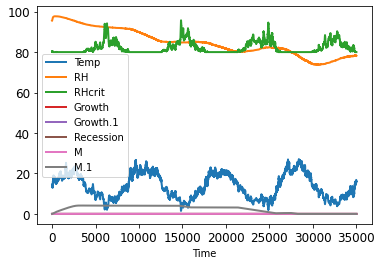

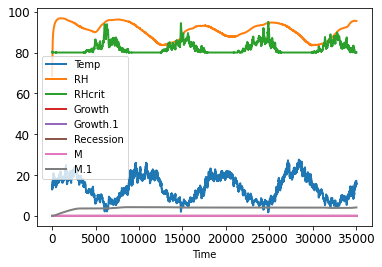

In [49]:
# plot

moldi.loc[:, ["Temp", "RH", "RHcrit", "Growth", "Growth.1", "Recession", "M", "M.1"]].plot(linewidth=2, fontsize=12)
plt.show()

moldii.loc[:, ["Temp", "RH", "RHcrit", "Growth", "Growth.1", "Recession", "M", "M.1"]].plot(linewidth=2, fontsize=12)
plt.show()

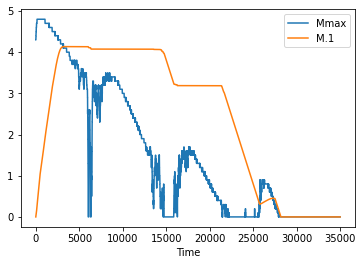

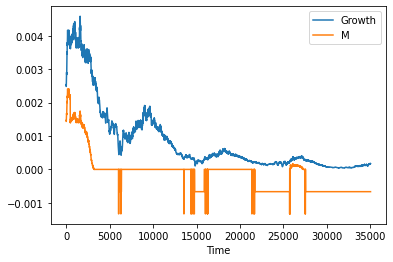

In [48]:
moldi.loc[:, ["Mmax", "M.1"]].plot()
plt.show()

moldi.loc[:, ["Growth", "M"]].plot()
plt.show()

In [19]:
moldi.describe()

,Temp,RH,RHcrit,Mmax,k1,k2,Growth,Growth.1,dryTime,Recession,M,M.1,atRisk,RHdiff
count,35017.000000,35017.000000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35017.000000,35017.000000,35016.000000
mean,13.627726,84.836916,82.087449,1.494931,0.445120,0.096948,0.000833,0.000122,1058.325109,-0.000252,-0.000130,2.442620,1679.576377,2.749213
std,6.076999,6.625669,2.856296,1.599147,0.088635,0.269228,0.001031,0.000410,1884.827592,0.000328,0.000581,1.669993,2027.286937,7.586311
min,1.490000,73.694600,80.000000,0.000000,0.386000,0.000000,0.000036,0.000000,0.000000,-0.001333,-0.001333,0.000000,0.000000,-14.492500
25%,8.160060,80.349200,80.000000,0.000000,0.386000,0.000000,0.000180,0.000000,0.000000,-0.000667,-0.000667,0.411650,0.000000,-3.075850
50%,12.530000,84.720000,80.600000,0.900000,0.386000,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,3.188104,662.000000,1.800700
75%,19.400000,91.520000,83.700000,3.000000,0.578000,0.000000,0.001163,0.000000,1400.250000,0.000000,0.000000,4.075437,3183.000000,8.790000
max,27.020500,97.720000,95.700000,4.800000,0.578000,0.999971,0.004589,0.002411,7506.000000,0.000000,0.002411,4.135437,7190.000000,17.720000


In [5]:
moldii.describe()

,Temp,RH,RHcrit,Mmax,k1,k2,Growth,Growth.1,dryTime,Recession,M,M.1,atRisk,M.1-1
count,35017.000000,35017.000000,35016.00000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35016.000000,35017.000000,35017.000000,35017.000000
mean,13.543960,90.866031,81.97877,2.924517,0.390162,0.113628,0.001380,0.000130,0.972327,-0.000012,0.000118,3.873612,4646.000657,3.873612
std,5.780823,3.809781,2.69908,1.127012,0.027960,0.278117,0.000815,0.000359,8.836255,0.000100,0.000376,0.701321,3579.401401,0.701321
min,1.733360,68.430900,80.00000,0.000000,0.386000,0.000000,0.000024,0.000000,0.000000,-0.001333,-0.001333,0.000000,0.000000,0.000000
25%,8.318450,88.076600,80.00000,2.300000,0.386000,0.000000,0.000792,0.000000,0.000000,0.000000,0.000000,3.894248,1575.000000,3.894248
50%,12.751700,91.545500,80.60000,3.200000,0.386000,0.000000,0.001189,0.000000,0.000000,0.000000,0.000000,4.086915,4032.000000,4.086915
75%,18.783300,93.910600,83.50000,3.800000,0.386000,0.000000,0.001860,0.000000,0.000000,0.000000,0.000000,4.095669,7185.000000,4.095669
max,27.549200,96.781000,95.00000,4.600000,0.578000,0.999869,0.004221,0.002074,152.000000,0.000000,0.002074,4.283002,13357.000000,4.283002


In [24]:

# from statsmodels.graphics.tsaplots import plot_acf,plot_pacfs
mendog = moldi.loc[:, ["RHcrit"]]
m2endog = moldi.loc[:, ["RHcrit"]]

mexog = moldii.loc[:, ["Temp"]]
m2exog = moldii.loc[:, ["Temp"]]

mArima = ARIMA(mendog, exog = mexog)
mResArima = mArima.fit()
print(mResArima.summary())

m2Arima = ARIMA(m2endog, exog = m2exog)
m2ResArima = m2Arima.fit()
print(m2ResArima.summary())

                               SARIMAX Results                                
Dep. Variable:                 RHcrit   No. Observations:                35017
Model:                          ARIMA   Log Likelihood              -66152.865
Date:                Tue, 22 Mar 2022   AIC                         132311.731
Time:                        15:30:44   BIC                         132337.122
Sample:                             0   HQIC                        132319.818
                              - 35017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.6303      0.022   4001.414      0.000      87.587      87.673
Temp          -0.4093      0.002   -271.138      0.000      -0.412      -0.406
sigma2         2.5614      0.019    135.821      0.0

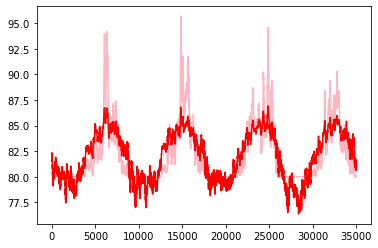

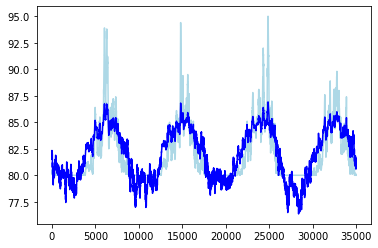

In [44]:
plt.plot(moldi.loc[:, ["RHcrit"]], color="lightpink")
plt.plot(mResArima.fittedvalues, color="red")
plt.show()
plt.plot(moldii.loc[:, ["RHcrit"]], color="lightblue")
plt.plot(m2ResArima.fittedvalues, color="blue")

In [28]:
miCorrMatrix = moldi.corr().abs()
miiCorrMatrix = moldii.corr().abs()

Moldi


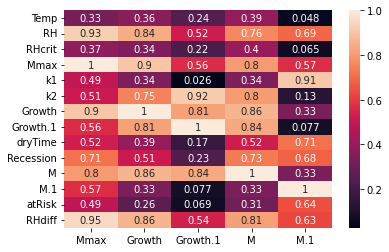

Moldii


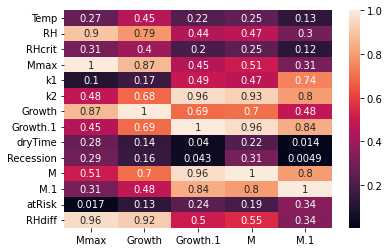

In [29]:
print("Moldi")
sns.heatmap(miCorrMatrix.loc[:, ["Mmax", "Growth", "Growth.1", "M", "M.1"]], annot=True)
plt.show()

print("Moldii")
sns.heatmap(miiCorrMatrix.loc[:, ["Mmax", "Growth", "Growth.1", "M", "M.1"]], annot=True)
plt.show()

In [30]:
X = moldi.loc[1:, ["Temp", "RH", "RHdiff", "atRisk", "Recession"]]

In [34]:
y = moldi.loc[1:, "M"]
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1234)

mimLogR = LinearRegression().fit(trainX, trainY)
predmimLR = mimLogR.predict(testX)
mse = np.mean((predmimLR - testY)**2)
print("Intercept: ", mimLogR.intercept_)
print("Coefs: ", mimLogR.coef_)
print("Score: ", mimLogR.score(trainX, trainY))
print("R2: ", metrics.r2_score(testY, predmimLR))
print("MSE: ", mse)

Intercept:  -0.0019033938129906132
Coefs:  [ 1.35325393e-05  2.17165353e-05  2.73830437e-05 -8.48036159e-08
  7.33333045e-01]
Score:  0.73973249477402
R2:  0.7419481129976593
MSE:  8.437236962518165e-08


In [35]:
y = moldi.loc[1:, "M.1"]
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1234)

mim1LogR = LinearRegression().fit(trainX, trainY)
predmim1LR = mim1LogR.predict(testX)
mse = np.mean((predmim1LR - testY)**2)
print("Intercept: ", mim1LogR.intercept_)
print("Coefs: ", mim1LogR.coef_)
print("Score: ", mim1LogR.score(trainX, trainY))
print("R2: ", metrics.r2_score(testY, predmim1LR))
print("MSE: ", mse)

Intercept:  -12.797266083710896
Coefs:  [-3.62687980e-02  1.85803863e-01 -9.53332285e-02  3.47705990e-04
  1.41724210e+03]
Score:  0.6884014555218907
R2:  0.6899551985896353
MSE:  0.8608356935102404


In [36]:
y = moldi.loc[1:, "Growth"]
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1234)

migLogR = LinearRegression().fit(trainX, trainY)
predmigLR = migLogR.predict(testX)
mse = np.mean((predmigLR - testY)**2)
print("Intercept: ", migLogR.intercept_)
print("Coefs: ", migLogR.coef_)
print("Score: ", migLogR.score(trainX, trainY))
print("R2: ", metrics.r2_score(testY, predmigLR))
print("MSE: ", mse)

Intercept:  -0.0076050132723559415
Coefs:  [ 3.47537773e-05  9.04316316e-05  7.25588695e-05 -7.89973916e-08
 -8.98024114e-01]
Score:  0.8361760374641904
R2:  0.8353338311474406
MSE:  1.7199349037439875e-07


In [38]:
y = moldi.loc[1:, "Mmax"]
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1234)

mimmLogR = LinearRegression().fit(trainX, trainY)
predmimmLR = mimmLogR.predict(testX)
mse = np.mean((predmimmLR - testY)**2)
print("Intercept: ", mimmLogR.intercept_)
print("Coefs: ", mimmLogR.coef_)
print("Score: ", mimmLogR.score(trainX, trainY))
print("R2: ", metrics.r2_score(testY, predmimmLR))
print("MSE: ", mse)

Intercept:  -4.083073581138018
Coefs:  [-1.07216938e-02  6.08155914e-02  1.60989967e-01  2.77400311e-05
 -2.97784157e+02]
Score:  0.9201707821976202
R2:  0.9215984025316089
MSE:  0.19934222793587458


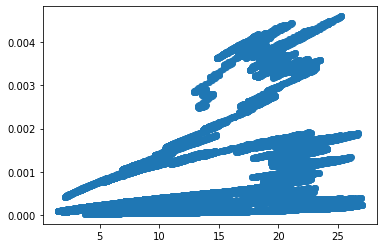

In [54]:
plt.scatter(moldi.loc[:,"Temp"], moldi.loc[:, "Growth"])

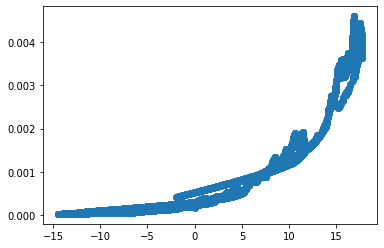

In [51]:
plt.scatter(moldi.loc[:,"RHdiff"], moldi.loc[:, "Growth"])